#Ejemplo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss
np.random.seed(42)
from sklearn.svm import SVC, LinearSVC

# a) Conjunto linealmente separable
X_lin, y_lin = make_classification(n_samples=500, n_features=2, n_informative=2,
                                   n_redundant=0, n_clusters_per_class=1,
                                   class_sep=2.0, random_state=7)
X_lin = StandardScaler().fit_transform(X_lin)

# b) Conjunto no lineal (moons)
X_nl, y_nl = make_moons(n_samples=500, noise=0.2, random_state=7)
X_nl = StandardScaler().fit_transform(X_nl)


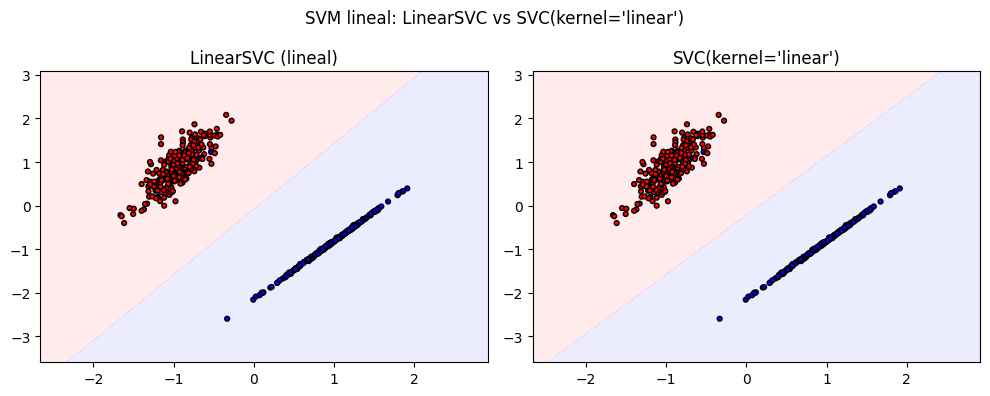

LinearSVC soporte (no expone SVs): no disponible
SVC(kernel='linear') soporte: 9


In [2]:
def plot_decision_boundary(clf, X, y, ax, title=""):
    xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 300),
                         np.linspace(X[:,1].min()-1, X[:,1].max()+1, 300))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.15, levels=np.arange(-0.5, 2, 1), cmap='bwr')
    ax.scatter(X[:,0], X[:,1], c=y, cmap='bwr', s=12, edgecolor='k')
    ax.set_title(title)

fig, ax = plt.subplots(1, 2, figsize=(10,4))

lin1 = LinearSVC(C=1.0, dual=False, max_iter=5000, random_state=0)
lin1.fit(X_lin, y_lin)
plot_decision_boundary(lin1, X_lin, y_lin, ax[0], "LinearSVC (lineal)")

lin2 = SVC(kernel='linear', C=1.0, random_state=0)
lin2.fit(X_lin, y_lin)
plot_decision_boundary(lin2, X_lin, y_lin, ax[1], "SVC(kernel='linear')")

plt.suptitle("SVM lineal: LinearSVC vs SVC(kernel='linear')")
plt.tight_layout()
plt.show()

print("LinearSVC soporte (no expone SVs):", "no disponible")
print("SVC(kernel='linear') soporte:", lin2.support_.shape[0])

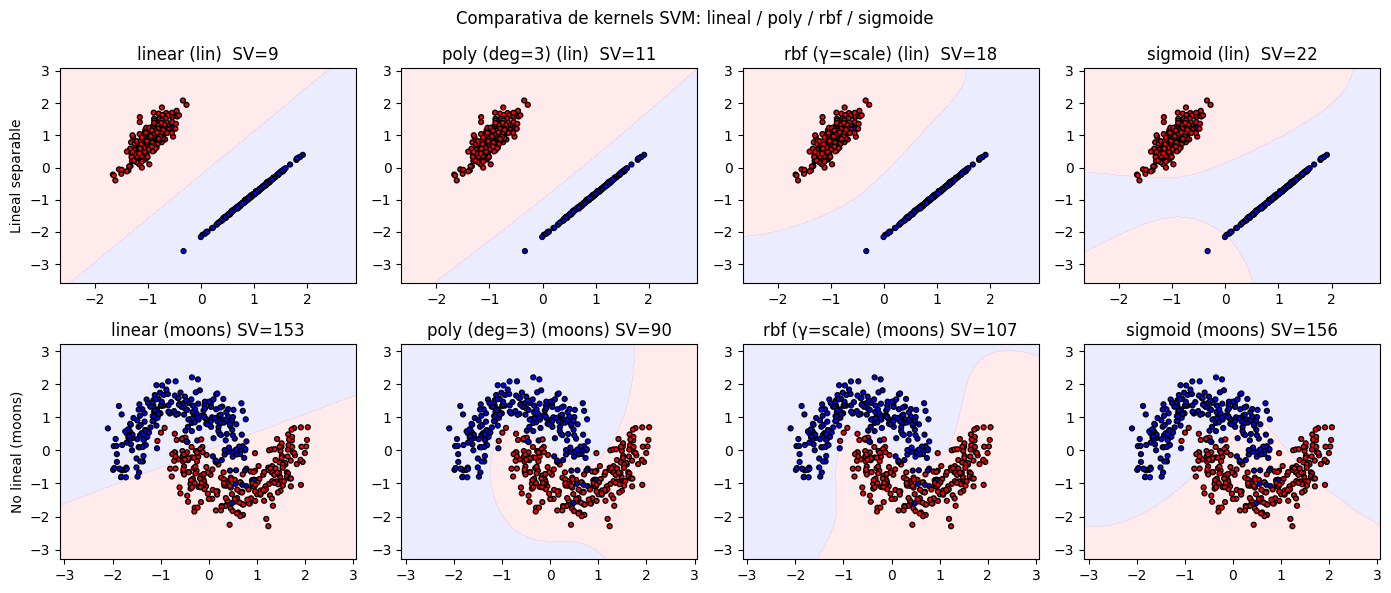

In [3]:
kernels = [
    ("linear", dict(kernel='linear', C=1.0)),
    ("poly (deg=3)", dict(kernel='poly', C=1.0, degree=3, coef0=1.0, gamma='scale')),
    ("rbf (γ=scale)", dict(kernel='rbf', C=1.0, gamma='scale')),
    ("sigmoid", dict(kernel='sigmoid', C=1.0, coef0=1.0, gamma='scale')),
]

fig, ax = plt.subplots(2, 4, figsize=(14,6))

# Arriba: dataset lineal
for j, (name, params) in enumerate(kernels):
    clf = SVC(**params, random_state=0)
    clf.fit(X_lin, y_lin)
    plot_decision_boundary(clf, X_lin, y_lin, ax[0,j], f"{name} (lin)  SV={clf.support_.shape[0]}")
# Abajo: dataset no lineal (moons)
for j, (name, params) in enumerate(kernels):
    clf = SVC(**params, random_state=0)
    clf.fit(X_nl, y_nl)
    plot_decision_boundary(clf, X_nl, y_nl, ax[1,j], f"{name} (moons) SV={clf.support_.shape[0]}")

ax[0,0].set_ylabel("Lineal separable")
ax[1,0].set_ylabel("No lineal (moons)")
plt.suptitle("Comparativa de kernels SVM: lineal / poly / rbf / sigmoide")
plt.tight_layout()
plt.show()

Mejores hiperparámetros (RBF, moons): {'C': 100, 'gamma': 1.0} score: 0.966


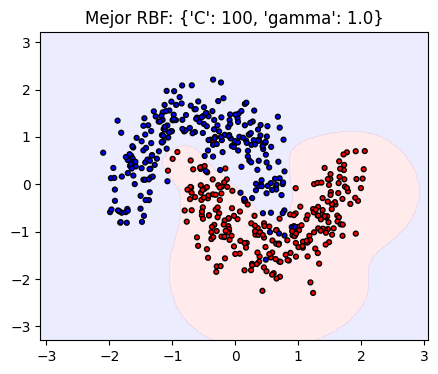

In [4]:
from sklearn.model_selection import GridSearchCV

param_grid = {"C": [0.1, 1, 10, 100],
              "gamma": ["scale", 0.5, 1.0, 2.0]}
clf = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, n_jobs=-1)
clf.fit(X_nl, y_nl)
print("Mejores hiperparámetros (RBF, moons):", clf.best_params_, "score:", clf.best_score_)
best = clf.best_estimator_

# Visualizar mejor modelo
fig, ax = plt.subplots(1,1, figsize=(5,4))
plot_decision_boundary(best, X_nl, y_nl, ax, f"Mejor RBF: {clf.best_params_}")
plt.show()

#Ejercicio

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

def plot_decision_boundary_2d(clf, X2, y, ax=None, title="", plot_support=True, cmap='bwr'):
    """
    X2 es bidimensional (por ejemplo, tras PCA(n_components=2)).
    Dibuja frontera y datos. Si clf tiene .support_, marca los SVs.
    """
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,4))
    x_min, x_max = X2[:, 0].min()-1, X2[:, 0].max()+1
    y_min, y_max = X2[:, 1].min()-1, X2[:, 1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.15, levels=np.arange(-0.5, Z.max()+1.5, 1), cmap=cmap)
    scatter = ax.scatter(X2[:, 0], X2[:, 1], c=y, cmap=cmap, s=15, edgecolor='k')
    # Marcar SV si aplica (SVC)
    if plot_support and hasattr(clf, "support_"):
        sv = clf.support_
        ax.scatter(X2[sv, 0], X2[sv, 1], s=70, facecolors='none', edgecolors='k', linewidths=1.2, label="SV")
        ax.legend(loc="best")
    ax.set_title(title)
    return ax


In [ ]:
data_bc = load_breast_cancer()
X_bc = data_bc.data
y_bc = data_bc.target  # 0 = malignant, 1 = benign

Xtr_bc, Xte_bc, ytr_bc, yte_bc = train_test_split(X_bc, y_bc, test_size=0.25, stratify=y_bc, random_state=0)

# Estandarizamos y proyectamos a 2D para visualización clara
scaler_bc = StandardScaler().fit(Xtr_bc)
Xtr_std = scaler_bc.transform(Xtr_bc)
Xte_std = scaler_bc.transform(Xte_bc)

pca_bc = PCA(n_components=2, random_state=0).fit(Xtr_std)
Xtr_bc_2d = pca_bc.transform(Xtr_std)
Xte_bc_2d = pca_bc.transform(Xte_std)

print("Breast Cancer -> X shape:", X_bc.shape, "Clases:", dict(zip(data_bc.target_names, np.bincount(y_bc))))


In [7]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_loss_and_grad(w, X, y, lam=1e-2):
    """
    w: (d,) ; X: (n,d) ; y in {0,1}
    loss = 1/n sum log(1+exp(-(2y-1)*<w,x>)) + lam/2 ||w||^2
    grad = -1/n sum ( (2y-1) x * sig(- (2y-1) <w,x>) ) + lam w
    """
    n = X.shape[0]
    ypm = 2*y - 1  # {0,1} -> {-1,+1}
    z = ypm * (X @ w)
    loss = np.mean(np.log(1 + np.exp(-z))) + 0.5*lam*np.dot(w, w)
    grad = -(X.T @ (ypm * (1 - sigmoid(z))))/n + lam*w
    return loss, grad

# Inicialización y GD
w = np.zeros(2)
eta = 0.5
epochs = 300
lam = 1e-2
hist = []

for t in range(epochs):
    loss, g = logistic_loss_and_grad(w, Xtr_bc_2d, ytr_bc, lam=lam)
    w = w - eta*g
    hist.append(loss)

print(f"Loss final GD: {hist[-1]:.4f}")

# Curva de pérdida
plt.figure(figsize=(5,3))
plt.plot(hist)
plt.xlabel("Iteración")
plt.ylabel("Pérdida logística")
plt.title("GD desde cero (Breast Cancer, PCA-2D)")
plt.grid(True, alpha=0.3)
plt.show()

# Evaluación y frontera (aprox lineal en 2D)
def predict_gd_linear(w, X):
    return (X @ w > 0).astype(int)

yhat_tr = predict_gd_linear(w, Xtr_bc_2d)
yhat_te = predict_gd_linear(w, Xte_bc_2d)
print("Acc train GD:", accuracy_score(ytr_bc, yhat_tr))
print("Acc test  GD:", accuracy_score(yte_bc, yhat_te))

# Dibujo de frontera: recta w^T x = 0
xx, yy = np.meshgrid(np.linspace(Xtr_bc_2d[:,0].min()-1, Xtr_bc_2d[:,0].max()+1, 400),
                     np.linspace(Xtr_bc_2d[:,1].min()-1, Xtr_bc_2d[:,1].max()+1, 400))
Z = (np.c_[xx.ravel(), yy.ravel()] @ w).reshape(xx.shape)

plt.figure(figsize=(5,4))
plt.contourf(xx, yy, (Z>0).astype(int), alpha=0.15, levels=1, cmap='bwr')
plt.contour(xx, yy, Z, levels=[0], colors='k', linewidths=2)
plt.scatter(Xtr_bc_2d[:,0], Xtr_bc_2d[:,1], c=ytr_bc, cmap='bwr', s=15, edgecolor='k')
plt.title("Frontera GD (regresión logística en PCA-2D)")
plt.show()

NameError: name 'Xtr_bc_2d' is not defined

In [ ]:
# - Cambia eta (0.1, 0.3, 0.8) y observa estabilidad/velocidad.
# - Cambia lam (1e-3, 1e-1) y compara el margen (norma de w) y performance.

In [ ]:
clf_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=2, random_state=0)),
    ("lr", LogisticRegression(penalty="l2", C=1/1e-2, solver="lbfgs", max_iter=1000, random_state=0))
])
clf_lr.fit(Xtr_bc, ytr_bc)
print("Acc train LR:", accuracy_score(ytr_bc, clf_lr.predict(Xtr_bc)))
print("Acc test  LR:", accuracy_score(yte_bc, clf_lr.predict(Xte_bc)))
print(confusion_matrix(yte_bc, clf_lr.predict(Xte_bc)))
print(classification_report(yte_bc, clf_lr.predict(Xte_bc), target_names=data_bc.target_names))


In [ ]:
data_iris = load_iris()
X_ir = data_iris.data
y_ir = data_iris.target  # 3 clases

Xtr_ir, Xte_ir, ytr_ir, yte_ir = train_test_split(X_ir, y_ir, test_size=0.25, stratify=y_ir, random_state=0)

scaler_ir = StandardScaler().fit(Xtr_ir)
Xtr_ir_std = scaler_ir.transform(Xtr_ir)
Xte_ir_std = scaler_ir.transform(Xte_ir)

pca_ir = PCA(n_components=2, random_state=0).fit(Xtr_ir_std)
Xtr_ir_2d = pca_ir.transform(Xtr_ir_std)
Xte_ir_2d = pca_ir.transform(Xte_ir_std)

print("Iris -> X shape:", X_ir.shape, "Clases:", data_iris.target_names)


In [ ]:
lin_linsvc = LinearSVC(C=1.0, dual=False, max_iter=10000, random_state=0)
lin_svc    = SVC(kernel="linear", C=1.0, random_state=0, decision_function_shape="ovr")

lin_linsvc.fit(Xtr_ir_2d, ytr_ir)
lin_svc.fit(Xtr_ir_2d, ytr_ir)

print("[Iris - PCA2D] Acc test LinearSVC:", accuracy_score(yte_ir, lin_linsvc.predict(Xte_ir_2d)))
print("[Iris - PCA2D] Acc test SVC(linear):", accuracy_score(yte_ir, lin_svc.predict(Xte_ir_2d)))
print("SVC(linear) #SV:", lin_svc.support_.shape[0])

fig, ax = plt.subplots(1,2, figsize=(10,4))
plot_decision_boundary_2d(lin_linsvc, Xtr_ir_2d, ytr_ir, ax=ax[0], title="LinearSVC (Iris, PCA-2D)", plot_support=False, cmap='tab10')
plot_decision_boundary_2d(lin_svc,    Xtr_ir_2d, ytr_ir, ax=ax[1], title="SVC(kernel='linear') (Iris, PCA-2D)", plot_support=True,  cmap='tab10')
plt.tight_layout()
plt.show()

In [ ]:
# - Cambia C (0.1, 1, 10) en ambos y observa cambios de frontera y #SV (solo SVC expone SV).

In [ ]:
kernels = [
    ("linear", dict(kernel="linear", C=1.0)),
    ("poly(d=3)", dict(kernel="poly", C=1.0, degree=3, gamma="scale", coef0=1.0)),
    ("rbf", dict(kernel="rbf", C=1.0, gamma="scale")),
]

fig, ax = plt.subplots(1, 3, figsize=(14,4))
for j, (name, params) in enumerate(kernels):
    clf = SVC(**params, random_state=0, decision_function_shape="ovr")
    clf.fit(Xtr_ir_2d, ytr_ir)
    plot_decision_boundary_2d(clf, Xtr_ir_2d, ytr_ir, ax=ax[j], title=f"{name} (Iris, PCA-2D)\nSV={clf.support_.shape[0]}", cmap='tab10')
plt.tight_layout()
plt.show()

# Evaluación en el test (en PCA-2D)
for name, params in kernels:
    clf = SVC(**params, random_state=0, decision_function_shape="ovr").fit(Xtr_ir_2d, ytr_ir)
    print(f"[{name}] Acc test (Iris, PCA-2D):", accuracy_score(yte_ir, clf.predict(Xte_ir_2d)))


In [ ]:
pipe_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", decision_function_shape="ovr", random_state=0))
])
param_grid = {"clf__C": [0.1, 1, 10, 100],
              "clf__gamma": ["scale", 0.1, 0.5, 1.0, 2.0]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
gs = GridSearchCV(pipe_rbf, param_grid, cv=cv, n_jobs=-1, scoring="accuracy")
gs.fit(Xtr_ir, ytr_ir)

print("Mejores hiperparámetros RBF (Iris full):", gs.best_params_, "score CV:", gs.best_score_)
best = gs.best_estimator_
print("Acc test mejor RBF:", accuracy_score(yte_ir, best.predict(Xte_ir)))
print(confusion_matrix(yte_ir, best.predict(Xte_ir)))
print(classification_report(yte_ir, best.predict(Xte_ir), target_names=data_iris.target_names))

In [ ]:
# - Cambia la métrica de scoring a 'f1_macro' y discute diferencias.
# - Compara #SV del mejor RBF (entrenando fuera del pipeline para inspeccionarlo) vs. lineal.